# Summary

This is the third notebook of this study, it is dedicated to classification system and metrics analytics. All notebooks follow the same structure:

Summary: a brief explanation of general objectives

Table of Contents: list of related content

Requirements: required packages

Data Loading: input data for analysis

Main activities: selected analysis, transformation or training for this specific notebook

# Table of Contents

1. Requirements
2. Data Loading
3. Metrics
4. Binary Classification
5. Multiclass Classification

# Requirements

In [1]:
#Load packages
import warnings
warnings.filterwarnings("ignore")

from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import recall_score
from random import random
from random import seed

from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [3]:
#train_images folder in drive
train_path = '/content/drive/My Drive/Colab Notebooks/train_images/'

In [4]:
#Loading master dataframe
df_master = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_master.csv')
df_master.head()

,ImageId,Defect,Defect_no,ClassId,EncodedPixels
0,88df5f0d8.jpg,yes,1,[3],['111052 12 111284 36 111517 58 111749 82 1119...
1,71b815a2d.jpg,yes,1,[3],['53666 54 53816 160 54018 214 54274 214 54530...
2,e863b1467.jpg,yes,1,[3],['92673 127 92929 253 93185 253 93441 253 9369...
3,a3fe8d17b.jpg,no,0,[0],NaN
4,8e30601c8.jpg,no,0,[0],NaN


In [5]:
#master dataframe shape
df_master.shape

(12568, 5)

In [6]:
#Selecting each image with at least 1 defect
train_img = df_master[df_master['Defect_no'] == 1]

train_img

,ImageId,Defect,Defect_no,ClassId,EncodedPixels
0,88df5f0d8.jpg,yes,1,[3],['111052 12 111284 36 111517 58 111749 82 1119...
1,71b815a2d.jpg,yes,1,[3],['53666 54 53816 160 54018 214 54274 214 54530...
2,e863b1467.jpg,yes,1,[3],['92673 127 92929 253 93185 253 93441 253 9369...
11,6f405f1e3.jpg,yes,1,[3],['4583 2 4839 5 5094 9 5350 11 5606 14 5862 16...
13,ff44fa556.jpg,yes,1,[3],['286291 3 286545 7 286799 11 287053 15 287306...
...,...,...,...,...,...
12555,efe30162b.jpg,yes,1,[3],['62341 1 62465 1 62595 5 62721 2 62849 9 6297...
12556,f2c12070d.jpg,yes,1,[3],['223834 3 224088 7 224342 11 224596 15 224850...
12558,a6ecee828.jpg,yes,1,[3],['179011 27 179126 73 179259 39 179375 80 1794...
12564,9d4b9f63c.jpg,yes,1,[4],['90075 3 90327 7 90579 12 90831 16 91083 21 9...


In [7]:
#Class distribution of defects
train_img.ClassId.value_counts()

[3]    4759
[1]     769
[4]     516
[2]     195
Name: ClassId, dtype: int64

In order to assure a balanced dataset, I'm imposing that each defect class will contain exactly 180 images, randomly selected, consequently, entire defect dataset will contain 720 (4*180) unique images. Balance was required to avoid a prediction bias towards the class with most images in favor of the class with least images.
The binary classificator will work on 1.440 labeled images, split in, 720 with at least 1 defect plus 720 with no defect. The multiclass classificator will work on 720 images, split in, 180 per each class. Both classificator systems will be assisted by a dataloader that splits data in train-test-validation. The dataloader also performed data augmentation itself.


In [8]:
#Splitting each defect image per ClassId.
"""
Note that most images with defect has at least 1 defect or no defect.
The following split follow the logic of filtering just mono ClassId, e, g:
ClassId = [0,1,2,3,4]
This way crossed defect are being discarded.
"""

seed = 98
sample_minor = 180
sample_major = 4*sample_minor

c0_df = df_master[df_master['ClassId'] == '[0]'].sample(n=sample_major, random_state=seed)
c1_df = df_master[df_master['ClassId'] == '[1]'].sample(n=sample_minor, random_state=seed)
c2_df = df_master[df_master['ClassId'] == '[2]'].sample(n=sample_minor, random_state=seed)
c3_df = df_master[df_master['ClassId'] == '[3]'].sample(n=sample_minor, random_state=seed)
c4_df = df_master[df_master['ClassId'] == '[4]'].sample(n=sample_minor, random_state=seed)

# Metrics

Below the metrics are defined in order to evaluate the training system. Once it's an image classification system, we need to use F1-score in which recall as well as precision are merged into a single metric.

In [9]:
# Metrics

def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For instance, it's a ratio of intersection area (y_true vs y_pred) over union (y_true + y_pred)
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'dice_coef':dice_coef,
    'f1_score_m':f1_score_m,
}

# Binary Classification

Following the schematic presented in Readme.md, the first classification system have the objective to identify if a given image has whether a defect or not. To achieve this goal, I'll be using a classification model very similar to UNet written in Keras, the input is an image reshape in length only from (256,1600,3) to (256,512,3). Inside the model you'll find many convolutional layers, max polling layers and dropouts. The output was setup as a densenet with 1 output with sigmoid as activation function.

In [ ]:
#dataset preparation as binary; half no defect + half with all defect equally balanced
binary_train_set = pd.concat([c0_df, c1_df, c2_df, c3_df, c4_df])
binary_train_set.reset_index(inplace=True, drop=True)
print(binary_train_set.shape)

(1440, 5)


In [ ]:
#split train-test-val
parcial_train, parcial_test = train_test_split(binary_train_set, test_size = 0.1, random_state=seed)
parcial_train, parcial_val = train_test_split(parcial_train, test_size = 0.2, random_state=seed)

In [ ]:
print(parcial_train.shape, parcial_val.shape, parcial_test.shape)

(1036, 5) (260, 5) (144, 5)


In [ ]:
#dataloader from keras with some augmentation

train_DataGenerator_2 = ImageDataGenerator(rescale=1./255.,
                                           shear_range=0.2, 
                                           zoom_range=0.05, 
                                           rotation_range=5, 
                                           width_shift_range=0.2, 
                                           height_shift_range=0.2, 
                                           horizontal_flip=True, 
                                           vertical_flip=True)

train_generator=train_DataGenerator_2.flow_from_dataframe(dataframe=parcial_train.astype(str),
                                            directory=train_path,
                                            x_col="ImageId",
                                            y_col="Defect_no",
                                            batch_size=32,
                                            class_mode='binary',
                                            target_size=(256,512))

test_DataGenerator_2 = ImageDataGenerator(rescale=1./255)

valid_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_val.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="Defect_no",
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(256,512))

Found 1036 validated image filenames belonging to 2 classes.
Found 260 validated image filenames belonging to 2 classes.


### Binary Model

In [ ]:
#Loading the model based on encoding-decoding Unet shape

base_model = keras.applications.xception.Xception(include_top = False, input_shape = (256,512,3))

# global spatial average pooling layer - GAPL
x = base_model.output
x = GlobalAveragePooling2D()(x)

# fully-connected layer - FCN
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# prediction layer - 1 outbut - binary classification
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 255, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### Binary Training

For the model, I've chosen Adam as a standard optimizer (default choice), binary crossentropy loss, because it's best suitable for problem involving binary classifications. In terms of metrics, as discussed above, accuracy, precision and recall are default choices in addition to F1-score. Model data will be exported to JSON file for further inspection and 30 epochs were defined as enough for this task. I've used Google Cloud (Colaboratory) to process this training job for free (K80 nvidia).

Reference for epochs, batch_size and optimizer were based on the following article from Medium.

Source: https://keras.io/api/optimizers/adam/

Source: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', f1_score_m, precision_m, recall_m])

model_path = '/content/drive/My Drive/Colab Notebooks/models/binary_class/'
    
checkpoint = ModelCheckpoint(model_path + 'model_binary_class.h5',
                     monitor='val_f1_score_m', 
                     mode='max', 
                     verbose=0, 
                     save_best_only=True,
                     save_weights_only=False)    
    
history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              epochs = 30,
                              callbacks = [checkpoint])

Epoch 1/30
33/33 [==============================] - 275s 8s/step - loss: 0.7020 - acc: 0.6757 - f1_score_m: 0.6527 - precision_m: 0.6958 - recall_m: 0.6512 - val_loss: 0.7861 - val_acc: 0.5154 - val_f1_score_m: 0.6810 - val_precision_m: 0.5233 - val_recall_m: 1.0000
Epoch 2/30
33/33 [==============================] - 64s 2s/step - loss: 0.5187 - acc: 0.7732 - f1_score_m: 0.7784 - precision_m: 0.7669 - recall_m: 0.8098 - val_loss: 0.6928 - val_acc: 0.5308 - val_f1_score_m: 0.6851 - val_precision_m: 0.5322 - val_recall_m: 1.0000
Epoch 3/30
33/33 [==============================] - 64s 2s/step - loss: 0.4278 - acc: 0.8002 - f1_score_m: 0.8110 - precision_m: 0.7902 - recall_m: 0.8603 - val_loss: 0.8769 - val_acc: 0.6231 - val_f1_score_m: 0.7420 - val_precision_m: 0.6038 - val_recall_m: 1.0000
Epoch 4/30
33/33 [==============================] - 61s 2s/step - loss: 0.3894 - acc: 0.8320 - f1_score_m: 0.8372 - precision_m: 0.8427 - recall_m: 0.8492 - val_loss: 0.8782 - val_acc: 0.7000 - val_f1_

In [ ]:
#Storing results in json file and history dataframe
import json
with open(model_path + 'binary_class_history.json', 'w') as f:
    json.dump(history.history, f)

history_bin_df = pd.DataFrame(history.history)

In [ ]:
#checking dataframe
history_bin_df.head()

,loss,acc,f1_score_m,precision_m,recall_m,val_loss,val_acc,val_f1_score_m,val_precision_m,val_recall_m
0,0.702011,0.675676,0.652713,0.695770,0.651183,0.786134,0.515385,0.680970,0.523260,1.000000
1,0.518744,0.773166,0.778392,0.766866,0.809795,0.692772,0.530769,0.685129,0.532198,1.000000
2,0.427755,0.800193,0.811041,0.790216,0.860269,0.876911,0.623077,0.742001,0.603789,1.000000
3,0.389405,0.832046,0.837191,0.842733,0.849218,0.878184,0.700000,0.736985,0.704711,0.791966
4,0.379919,0.846525,0.855264,0.847693,0.882803,1.741822,0.692308,0.588976,0.761231,0.496601


Text(0, 0.5, 'Results')

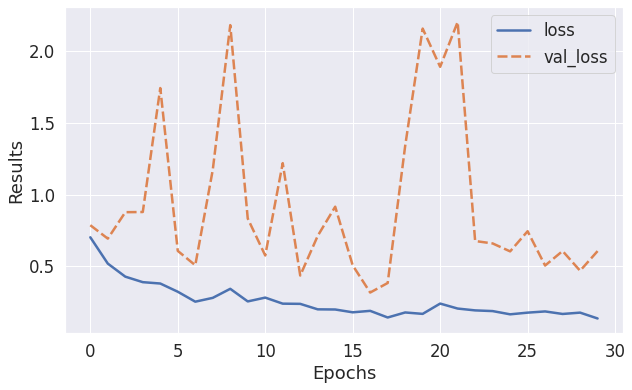

In [ ]:
#Plotting loss vs validation loss for binary model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_bin_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

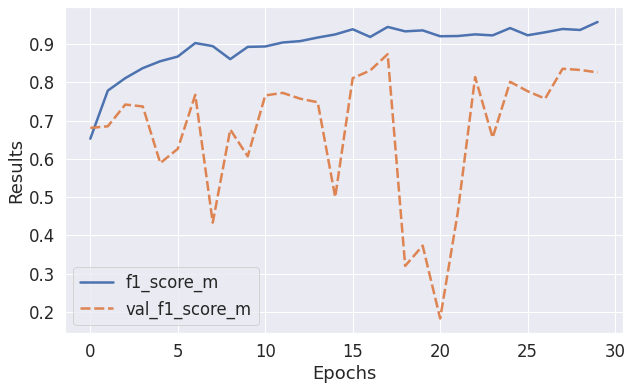

In [ ]:
#Plotting f1_score vs validation_f1_score for binary model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_bin_df[['f1_score_m', 'val_f1_score_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

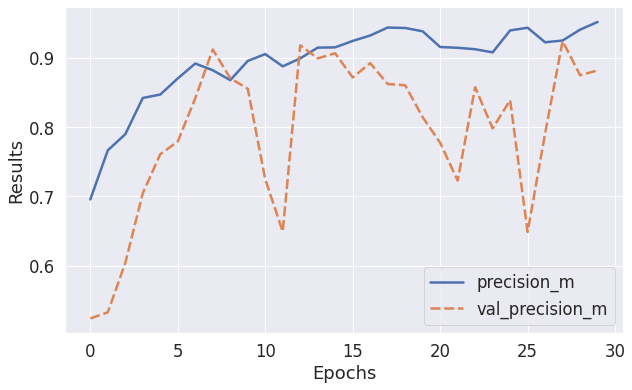

In [ ]:
#Plotting precision vs validation_precision for binary model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_bin_df[['precision_m', 'val_precision_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

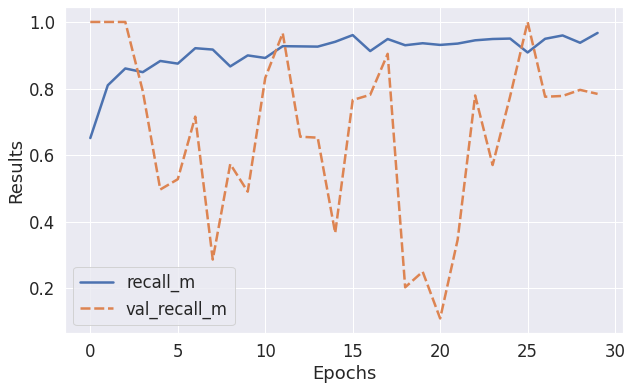

In [ ]:
#Plotting recall vs validation_recall for binary model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_bin_df[['recall_m', 'val_recall_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

### Binary Evaluation

In [ ]:
# Loading best model trained on binary classification
model = load_model(model_path + 'model_binary_class.h5', 
                   custom_objects=dependencies)

In [ ]:
train_generator=train_DataGenerator_2.flow_from_dataframe(dataframe=parcial_train.astype(str),
                                            directory=train_path,
                                            x_col="ImageId",
                                            y_col="Defect",
                                            batch_size=32,
                                            class_mode='binary',
                                            target_size=(256,512),
                                            shuffle=False)

valid_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_val.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="Defect",
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(256,512),
                                                 shuffle=False)

test_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_test.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="Defect",
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(256,512),
                                                 shuffle=False)

Found 1036 validated image filenames belonging to 2 classes.
Found 260 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.


In [ ]:
train_evaluate = model.evaluate(train_generator,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

33/33 [==============================] - 38s 1s/step - loss: 0.2388 - acc: 0.9180 - f1_score_m: 0.9215 - precision_m: 0.8842 - recall_m: 0.9661
Train set evaluation score:


,
binary_crossentropy,0.238817
acc,0.917954
f1_score_m,0.921498
precision_m,0.884169
recall_m,0.966085


In [ ]:
val_evaluate = model.evaluate(valid_generator,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(val_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

9/9 [==============================] - 3s 333ms/step - loss: 0.3835 - acc: 0.8846 - f1_score_m: 0.8908 - precision_m: 0.8826 - recall_m: 0.9042
Validation set evaluation score:


,
binary_crossentropy,0.383536
acc,0.884615
f1_score_m,0.890784
precision_m,0.882574
recall_m,0.904177


In [ ]:
test_evaluate = model.evaluate(test_generator,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['binary_crossentropy','acc','f1_score_m','precision_m','recall_m'])

5/5 [==============================] - 18s 4s/step - loss: 0.3089 - acc: 0.9167 - f1_score_m: 0.9256 - precision_m: 0.9129 - recall_m: 0.9392
Test set evaluation score:


,
binary_crossentropy,0.308860
acc,0.916667
f1_score_m,0.925556
precision_m,0.912857
recall_m,0.939231


The binary classification system was trained with no issues using gpu K80 at Colab. The selected dataset could be bigger, in order to achieve a higher accuracy. As discussed above, a total of 1440 unique images was used as input dataset in a universe of more than 12k. Due to ths small selected pool, model's weight lack of 'knowledge' about each defect feature.



# Multiclass Classification

Following the schematic presented in Readme.md, the second classification system has the objective to identify which defect a given image has on it. To achieve this goal, I'll be using a classification model very similar to unet written in Keras, the input is an image reshape in length only from (256,1600,3) to (256,512,3). Inside the model you'll find many convolutional layers, max polling layers and dropouts. The output was setup as a densenet with 4 outputs (one output for each single class) with sigmoid as activation function.

Reference for epochs, batch_size and optimizer were based on the following article from Medium.

Source: https://keras.io/api/optimizers/adam/

Source: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [24]:
multi_train_set = pd.concat([c1_df, c2_df, c3_df, c4_df])
multi_train_set.reset_index(inplace=True, drop=True)
print(multi_train_set.shape)

(720, 5)


In [25]:
parcial_train, parcial_test = train_test_split(multi_train_set, test_size = 0.1, random_state=seed)
parcial_train, parcial_val = train_test_split(parcial_train, test_size = 0.2, random_state=seed)

In [15]:
print(parcial_train.shape, parcial_val.shape, parcial_test.shape)

(518, 5) (130, 5) (72, 5)


In [26]:
train_DataGenerator_2 = ImageDataGenerator(rescale=1./255.,
                                           shear_range=0.2,
                                           zoom_range=0.05,
                                           rotation_range=5,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True,
                                           vertical_flip=True)

train_generator=train_DataGenerator_2.flow_from_dataframe(dataframe=parcial_train.astype(str),
                                            directory=train_path,
                                            x_col="ImageId",
                                            y_col="ClassId",
                                            batch_size=16,
                                            class_mode='categorical',
                                            classes=['[1]', '[2]', '[3]', '[4]'],
                                            target_size=(256,512))

test_DataGenerator_2 = ImageDataGenerator(rescale=1./255)

valid_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_val.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="ClassId",
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 classes=['[1]', '[2]', '[3]', '[4]'],
                                                 target_size=(256,512))

Found 518 validated image filenames belonging to 4 classes.
Found 130 validated image filenames belonging to 4 classes.


### Multiclass Model

In [17]:
#Load multi class classification model

base_model = keras.applications.xception.Xception(include_top = False, input_shape = (256,512,3))

# global spatial average pooling layer - GAPL
x = base_model.output
x = GlobalAveragePooling2D()(x)

# fully-connected layers - FCN
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# prediction layer - 4 outputs - 1 per each class
predictions = Dense(4, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 255, 32) 0           block1_conv1_bn[0][0]            
______________________

### Multiclass Training

For the model, I've chosen Adam as a standard optimizer (default choice), categorical crossentropy loss, because it's best suitable for problem involving multiclass classification problems. In terms of metrics, as discussed above, accuracy, precision and recall are default choices in addition to F1-score. Model data will be exported to JSON file for further inspection and 30 epochs were defined as enough for this task. I've used Google Cloud (Colaboratory) to process this training job for free (K80 nvidia).

In [27]:
#model training setup
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc', f1_score_m, precision_m, recall_m])


model_path = '/content/drive/My Drive/Colab Notebooks/models/multiclass_categorical/'

checkpoint = ModelCheckpoint(model_path + 'model_multiclass_categorical.h5',
                     monitor='val_f1_score_m',
                     mode='max', 
                     verbose=0, 
                     save_best_only=True,
                     save_weights_only=False)

history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              epochs = 30, 
                              callbacks = [checkpoint])

Epoch 1/30
33/33 [==============================] - 33s 997ms/step - loss: 0.5688 - acc: 0.8224 - f1_score_m: 0.8060 - precision_m: 0.7513 - recall_m: 0.8718 - val_loss: 2.3491 - val_acc: 0.4385 - val_f1_score_m: 0.5807 - val_precision_m: 0.5002 - val_recall_m: 0.6944
Epoch 2/30
33/33 [==============================] - 32s 982ms/step - loss: 0.6509 - acc: 0.8050 - f1_score_m: 0.7367 - precision_m: 0.6533 - recall_m: 0.8491 - val_loss: 2.0602 - val_acc: 0.6923 - val_f1_score_m: 0.7029 - val_precision_m: 0.6281 - val_recall_m: 0.8056
Epoch 3/30
33/33 [==============================] - 29s 882ms/step - loss: 0.5483 - acc: 0.8263 - f1_score_m: 0.7898 - precision_m: 0.7247 - recall_m: 0.8712 - val_loss: 1.0388 - val_acc: 0.7846 - val_f1_score_m: 0.6799 - val_precision_m: 0.5879 - val_recall_m: 0.8125
Epoch 4/30
33/33 [==============================] - 29s 873ms/step - loss: 0.4776 - acc: 0.8417 - f1_score_m: 0.8294 - precision_m: 0.7653 - recall_m: 0.9091 - val_loss: 1.1069 - val_acc: 0.753

In [28]:
#Storing results in json file and history dataframe
import json
with open(model_path + 'multiclass_categorical_history.json', 'w') as f:
    json.dump(history.history, f)

history_mul_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Results')

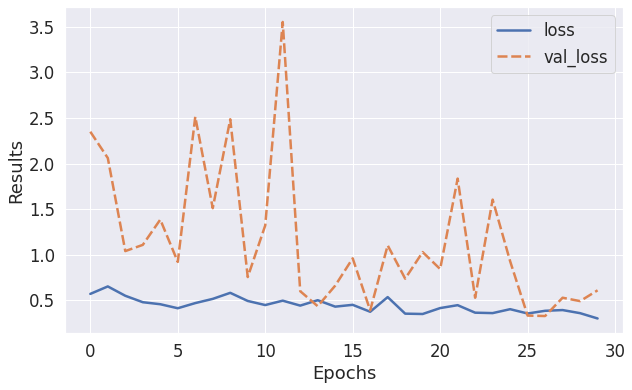

In [29]:
#Plotting loss vs validation loss for multiclass model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_mul_df[['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

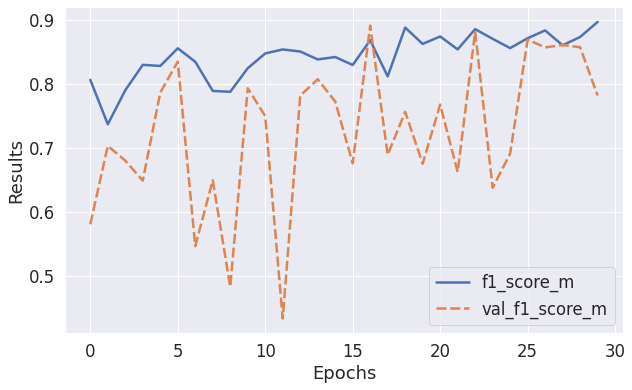

In [30]:
#Plotting f1_score vs validation_f1_score for multiclass model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_mul_df[['f1_score_m', 'val_f1_score_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

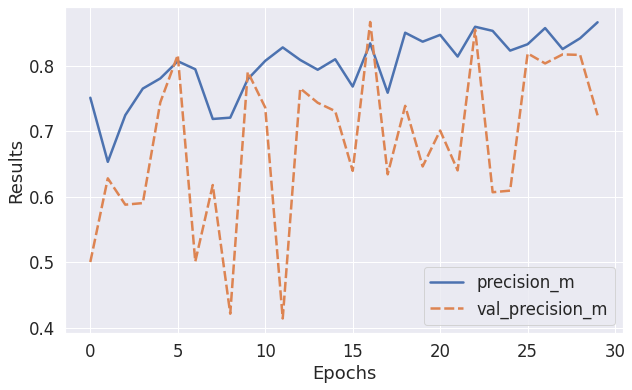

In [31]:
#Plotting precision vs validation_precision for multiclass model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_mul_df[['precision_m', 'val_precision_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

Text(0, 0.5, 'Results')

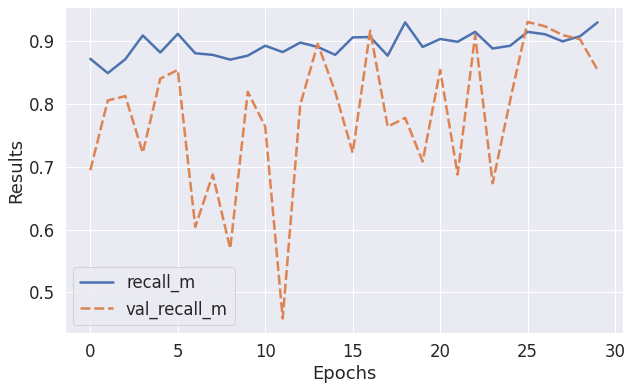

In [32]:
#Plotting recall vs validation_recall for multiclass model
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=history_mul_df[['recall_m', 'val_recall_m']])
plt.xlabel('Epochs')
plt.ylabel('Results')

### Multiclass Evaluation

In [33]:
model = load_model(model_path + 'model_multiclass_categorical.h5', 
                   custom_objects=dependencies)

In [34]:
train_generator=train_DataGenerator_2.flow_from_dataframe(dataframe=parcial_train.astype(str),
                                            directory=train_path,
                                            x_col="ImageId",
                                            y_col="ClassId",
                                            batch_size=16,
                                            class_mode='categorical',
                                            classes=['[1]', '[2]', '[3]', '[4]'],
                                            target_size=(256,512),
                                            shuffle=False)

valid_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_val.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="ClassId",
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 classes=['[1]', '[2]', '[3]', '[4]'],
                                                 target_size=(256,512),
                                                 shuffle=False)

test_generator=test_DataGenerator_2.flow_from_dataframe(dataframe=parcial_test.astype(str),
                                                 directory=train_path,
                                                 x_col="ImageId",
                                                 y_col="ClassId",
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 classes=['[1]', '[2]', '[3]', '[4]'],
                                                 target_size=(256,512),
                                                 shuffle=False)

Found 518 validated image filenames belonging to 4 classes.
Found 130 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [35]:
train_evaluate = model.evaluate(train_generator,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_evaluate,columns = [' '], index=['categorical_crossentropy','acc','f1_score_m','precision_m','recall_m'])

33/33 [==============================] - 19s 570ms/step - loss: 0.2819 - acc: 0.8938 - f1_score_m: 0.8940 - precision_m: 0.8671 - recall_m: 0.9242
Train set evaluation score:


,
categorical_crossentropy,0.281925
acc,0.893822
f1_score_m,0.893985
precision_m,0.867077
recall_m,0.924242


In [36]:
val_evaluate = model.evaluate(valid_generator,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(val_evaluate,columns = [' '], index=['categorical_crossentropy','acc','f1_score_m','precision_m','recall_m'])

9/9 [==============================] - 2s 168ms/step - loss: 0.3879 - acc: 0.9000 - f1_score_m: 0.8890 - precision_m: 0.8641 - recall_m: 0.9167
Validation set evaluation score:


,
categorical_crossentropy,0.387892
acc,0.900000
f1_score_m,0.888984
precision_m,0.864135
recall_m,0.916667


In [37]:
test_evaluate = model.evaluate(test_generator,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(test_evaluate,columns = [' '], index=['categorical_crossentropy','acc','f1_score_m','precision_m','recall_m'])

5/5 [==============================] - 15s 3s/step - loss: 0.3204 - acc: 0.8472 - f1_score_m: 0.8598 - precision_m: 0.8459 - recall_m: 0.8750
Test set evaluation score:


,
categorical_crossentropy,0.320426
acc,0.847222
f1_score_m,0.859759
precision_m,0.845915
recall_m,0.875000


The multiclass classification system was trained with no issues using gpu K80 at Colab. The selected dataset could be bigger, in order to achieve a higher accuracy. As discussed above, a total of 720 unique images was used as input dataset in a universe of more than 12k, even smaller than binary classification. Due to this small selected pool, model's weight lack of 'knowledge' about each defect feature.